# Summary of non-canonical pairs analysis

# Summary

## How does percent under -5.45 vary by pair type

[For non-canonical pairs most likely to mistaken as canonical pairs: AG at 19%](#percent-under--545)<br>

Summary table for cat:
| cat      | % < -5.45   |   Count |
|:---------|:------------|--------:|
| A in A-G | 19.26%      |   16995 |
| C in C-U | 14.29%      |   20636 |
| C in C-A | 6.76%       |   18410 |
| C in C-C | 6.72%       |   14564 |
| A in A-A | 6.63%       |   26446 |
| A in A-C | 3.43%       |   18410 |


[There is a higher percentage WC like pairs for A in A-C, A in A-G, and C in C-A in 1x1 then all](#percent-under--545-for-1x1)<br>
This is not seen for C in C-U, A in A-A and C in C-C<br>


Summary table for cat for 1x1
| cat      | % < -5.45   |   Count |
|:---------|:------------|--------:|
| C in C-A | 33.09%      |     674 |
| A in A-G | 29.31%      |     563 |
| A in A-C | 17.21%      |     674 |
| C in C-U | 7.21%       |     624 |
| A in A-A | 4.62%       |     866 |
| C in C-C | 0.89%       |     672 |


[There are no apparent trends by junction size](#by-topology-size)<br>



## Sequence preferences summary 
[sequence preferences section](#sequence-preferences)

### Summary of sequence preferences
Generally all c pairs have some sequence preference where pyrimidines stacks are more likely to lead to lower reactivity. This may be because they are poor stackers which allow the base pair to rotate more freely to form hydrogen bonds. This again reinforences the idea of the balance between hydrogen bonds and stacking interactions. 

### A in A-A sequence preferences summary
[Not that strong preference there is some preference from A 5' and 3'](#a-in-a-a-sequence-preferences)

### A in A-C sequence preferences summary
[Not that strong preference there is some preference from GG and UU](#a-in-a-c-sequence-preferences)

### A in A-G sequence preferences summary
[No strong preferences for A in A-G](#a-in-a-g-sequence-preferences)

### C in C-A sequence preferences summary
[Strong pyrimidine preferences for C in C-A](#a-in-a-c-sequence-preferences)

Summary table for p5_res:
| p5_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| C        | 18.57%          |    4793 |
| G        | 5.51%           |    2760 |
| U        | 2.41%           |    5941 |
| A        | 1.20%           |    4916 |

Summary table for p3_res:
| p3_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| U        | 11.49%          |    3725 |
| A        | 7.03%           |    7764 |
| C        | 5.53%           |    3945 |
| G        | 1.75%           |    2976 |


### C in C-C sequence preferences summary
[CC has strong preference for pyrimidine more for C](#c-in-c-c-sequence-preferences)

CC has strong preference for pyrimidine 
Summary table for stack_type:
| stack_type      | % Under -5.45   |   Count |
|:----------------|:----------------|--------:|
| both_pyrimidine | 15.07%          |    5536 |
| mixed           | 1.96%           |    7407 |
| both_purine     | 0.00%           |    1621 |

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CU        | 29.77%          |     813 |
| CC        | 27.76%          |    1275 |

### C in C-U sequence preferences summary
[Strong preferences for 3' U](#c-in-c-u-sequence-preferences)

Summary table for p3_res:
| p3_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| U        | 40.22%          |    6867 |
| A        | 3.34%           |    4104 |
| C        | 0.74%           |    5707 |
| G        | 0.20%           |    3958 |



## Summary of sequence preferences for 2x2

All trends are the same as for all but are mostly enhanced for C pairs

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress, ttest_ind
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from tabulate import tabulate
import py3Dmol

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    plot_motif_boxplot_stripplot,
    plot_violins_w_percent,
    plot_violins_w_percent_groups,
    format_small_plot,
)
from dms_3d_features.format_tables import (
    dataframe_column_table,
    generate_threshold_summary,
)
from dms_3d_features.stats import r2, check_pairwise_statistical_significance

## extra functions

In [2]:
def visualize_molecule(row, width=400, height=300):
    viewer = py3Dmol.view(width=width, height=height)
    viewer.addModel(open("../" + row["pdb_path"], "r").read(), "pdb")

    # Set color scheme for nucleotides
    nucleotide_colors = {"A": "red", "U": "green", "C": "blue", "G": "orange"}
    for nuc, color in nucleotide_colors.items():
        viewer.setStyle({"resn": nuc}, {"stick": {"color": color}})

    viewer.zoomTo()

    residue_number = row["pdb_r_pos"]
    viewer.addStyle({"resi": str(residue_number)}, {"stick": {"color": "magenta"}})

    # Highlight N1 for A or N3 for C
    if row["r_nuc"] == "A":
        viewer.addStyle(
            {"resi": str(residue_number), "atom": "N1"},
            {"sphere": {"radius": 1.0, "color": "magenta"}},
        )
    elif row["r_nuc"] == "C":
        viewer.addStyle(
            {"resi": str(residue_number), "atom": "N3"},
            {"sphere": {"radius": 1.0, "color": "magenta"}},
        )

    return viewer

### plotting

In [3]:
def plot_residue_trends(df, color="tab:gray", col="ln_r_data"):
    fig = plt.figure(figsize=(3.0, 3.0), dpi=200)
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[:, 1])

    # 5' Residue
    data_range = df[col].max() - df[col].min()
    extra_space = 0.4 * data_range
    xlim_min = df[col].min() - extra_space
    xlim_max = df[col].max()

    plot_violins_w_percent(
        df,
        col,
        "p5_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax1,
    )
    ax1.set_ylabel("5' Residue", labelpad=2)
    ax1.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax1)

    # 3' Residue
    plot_violins_w_percent(
        df,
        col,
        "p3_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax2,
    )
    ax2.set_ylabel("3' Residue", labelpad=2)
    ax2.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax2)

    # Residue Stack
    plot_violins_w_percent(
        df,
        col,
        "r_stack",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax3,
    )
    ax3.set_ylabel("Residue Stack", labelpad=2)
    ax3.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax3)
    plt.tight_layout()

In [4]:
def plot_flanking_pairs_distribution(df):
    # Combine the flanking pairs into a single column
    df["flanking_pairs"] = df["m_second_flank_bp_5p"] + "-" + df["m_second_flank_bp_3p"]
    # Calculate mean r_data_ratio for each flanking pair
    mean_r_data_ratio = (
        df.groupby("flanking_pairs")["r_data_ratio"].mean().sort_values(ascending=False)
    )
    # Create the rotated violin plot
    plt.figure(figsize=(5, 4))
    sns.violinplot(
        x="r_data_ratio",
        y="flanking_pairs",
        data=df,
        order=mean_r_data_ratio.index[::-1],
        cut=0,
        orient="h",
        density_norm="width",
    )
    # Customize the plot
    plt.title("Distribution of r_data_ratio for Different Flanking Pairs")
    plt.xlabel("r_data_ratio")
    plt.ylabel("Flanking Pairs (5' - 3')")
    # Add count labels
    counts = df["flanking_pairs"].value_counts()
    for i, flanking_pair in enumerate(mean_r_data_ratio.index[::-1]):
        count = counts[flanking_pair]
        plt.text(plt.xlim()[1] + 0.5, i, f"n={count}", ha="left", va="center")

### summary tables

In [5]:
def create_summary_table(df, y_column):
    # Calculate percentages and counts
    summary = []
    for y_value in df[y_column].unique():
        group = df[df[y_column] == y_value]
        percent_over = (group["ln_r_data"] < -5.45).mean() * 100
        count = len(group)
        summary.append([y_value, f"{percent_over:.2f}%", count])

    # Sort by percentage descending
    summary.sort(key=lambda x: float(x[1][:-1]), reverse=True)

    # Create table
    headers = [y_column, "% Under -5.45", "Count"]
    table = tabulate(summary, headers=headers, tablefmt="pipe", floatfmt=".2f")

    print(f"Summary table for {y_column}:")
    print(table)

In [6]:
def analyze_flanking_pairs(df):
    # Calculate the mean of r_data_ratio for each combination of m_second_flank_bp_5p and m_second_flank_bp_3p
    mean_r_data_ratio = (
        df.groupby(["m_second_flank_bp_5p", "m_second_flank_bp_3p"])["r_data_ratio"]
        .mean()
        .reset_index()
    )
    # Pivot the table to create a matrix-like structure
    pivot_table = mean_r_data_ratio.pivot(
        index="m_second_flank_bp_5p",
        columns="m_second_flank_bp_3p",
        values="r_data_ratio",
    )
    # Sort the index and columns alphabetically
    pivot_table = pivot_table.sort_index().sort_index(axis=1)
    # Display the results as a styled table
    display(pivot_table.style.format("{:.1f}").background_gradient(cmap="YlOrRd"))
    # Calculate the count of occurrences for each combination
    count_table = (
        df.groupby(["m_second_flank_bp_5p", "m_second_flank_bp_3p"])
        .size()
        .reset_index(name="count")
    )
    pivot_count = count_table.pivot(
        index="m_second_flank_bp_5p", columns="m_second_flank_bp_3p", values="count"
    )
    pivot_count = pivot_count.sort_index().sort_index(axis=1)
    # Display the count table
    display(pivot_count.style.format("{:.1f}").background_gradient(cmap="Blues"))

### misc

In [7]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "both_pyrimidine"
    elif row["both_purine"]:
        return "both_purine"
    else:
        return "mixed"

In [8]:
def calculate_side_diff(x):
    sides = x.split("x")
    return str(abs(int(sides[0]) - int(sides[1])))

## load data

In [9]:
DATA_PATH = "../data"

In [10]:
df_constructs = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df["stack_type"] = df.apply(assign_stack_type, axis=1)
df["side_diff"] = df["m_token"].apply(calculate_side_diff)
# pdb dataframe
df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")

In [80]:
df_pdb.iloc[0]

m_sequence                                                             AAAC_GCU
r_nuc                                                                         A
pdb_r_pos                                                                     3
r_type                                                                       WC
pdb_r_bp_type                                                               cWW
pdb_r_pair                                                                  A-U
no_of_conformations                                                           1
no_of_interactions                                                            1
no_of_partner_interactions                                                    1
pdb_name                                         TWOWAY.6NY2.1-2.GCU-AAAC.0.pdb
pdb_path                      data/pdbs_w_2bp/AAAC_GCU/TWOWAY.6NY2.1-2.GCU-A...
pdb_res                                                                     3.2
both_purine                             

# All residues

## percent under -5.45

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:426: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


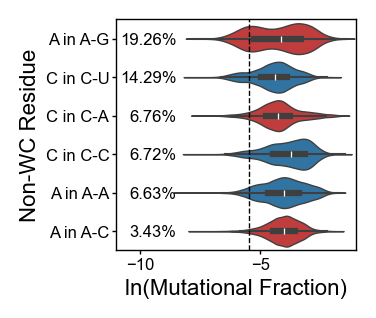

In [77]:
df_non_wc_pair = df.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != ''"
).copy()
df_non_wc_pair = df_non_wc_pair.query("likely_pair != 'AU'")
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_non_wc_pair,
    "ln_r_data",
    "cat",
    gt_lt="less",
    xlim=(-11, -1),
    text_offset=2.5,
    colors=["tab:red", "tab:blue", "tab:red", "tab:blue", "tab:blue", "tab:red"],
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Non-WC Residue", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
format_small_plot(ax)

In [12]:
df_non_wc_pair = df.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != ''"
).copy()
df_non_wc_pair = df_non_wc_pair.query("likely_pair != 'AU'")
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)
generate_threshold_summary(df_non_wc_pair, "cat", greater_than=False)

Summary table for cat:
| cat      | % < -5.45   |   Count |
|:---------|:------------|--------:|
| A in A-G | 19.26%      |   16995 |
| C in C-U | 14.29%      |   20636 |
| C in C-A | 6.76%       |   18410 |
| C in C-C | 6.72%       |   14564 |
| A in A-A | 6.63%       |   26446 |
| A in A-C | 3.43%       |   18410 |


## percent under -5.45 for 1x1

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:426: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


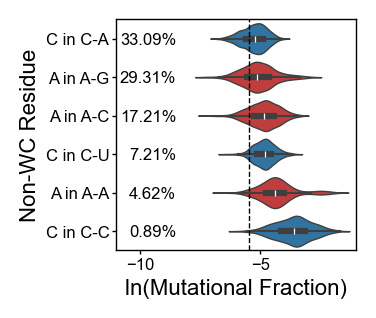

In [13]:
df_non_wc_pair = df.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and m_token == '1x1'"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_non_wc_pair,
    "ln_r_data",
    "cat",
    gt_lt="less",
    xlim=(-11, -1),
    text_offset=2.5,
    colors=["tab:blue", "tab:red", "tab:red", "tab:blue", "tab:red", "tab:blue"],
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Non-WC Residue", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
format_small_plot(ax)

In [14]:
df_non_wc_pair = df.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and m_token == '1x1'"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)
generate_threshold_summary(df_non_wc_pair, "cat", greater_than=False)

Summary table for cat:
| cat      | % < -5.45   |   Count |
|:---------|:------------|--------:|
| C in C-A | 33.09%      |     674 |
| A in A-G | 29.31%      |     563 |
| A in A-C | 17.21%      |     674 |
| C in C-U | 7.21%       |     624 |
| A in A-A | 4.62%       |     866 |
| C in C-C | 0.89%       |     672 |


In [97]:
df_non_wc_pair = df.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and m_token == '1x1'"
).copy()

# Calculate the percentage over the threshold for the whole set
threshold = -5.45
percent_over_threshold = (df_non_wc_pair["ln_r_data"] < threshold).mean() * 100

print(f"Percentage over threshold for the whole set: {percent_over_threshold:.2f}%")

Percentage over threshold for the whole set: 14.61%


In [98]:
df_non_wc_pair = df.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and m_token == '2x2'"
).copy()

# Calculate the percentage over the threshold for the whole set
threshold = -5.45
percent_over_threshold = (df_non_wc_pair["ln_r_data"] < threshold).mean() * 100

print(f"Percentage over threshold for the whole set: {percent_over_threshold:.2f}%")

Percentage over threshold for the whole set: 9.00%


/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:426: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


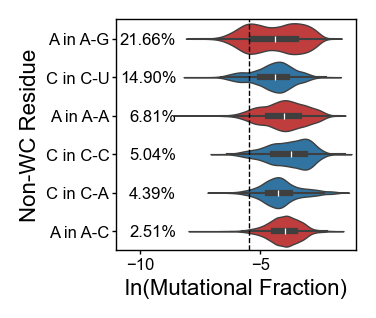

In [104]:
df_non_wc_pair = df.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and m_token == '2x2'"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_non_wc_pair,
    "ln_r_data",
    "cat",
    gt_lt="less",
    xlim=(-11, -1),
    text_offset=2.5,
    colors=["tab:red", "tab:blue", "tab:red", "tab:blue", "tab:blue", "tab:red"],
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Non-WC Residue", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
format_small_plot(ax)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:426: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


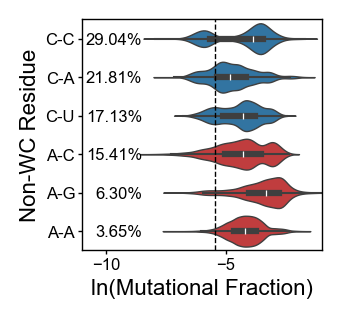

In [84]:
df_non_wc_pair = df_pdb.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')"
).copy()
valid_pairs = ["C-A", "C-C", "C-U", "A-A", "A-C", "A-G"]
df_non_wc_pair = df_non_wc_pair.query("pdb_r_pair in @valid_pairs")
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_non_wc_pair,
    "ln_r_data",
    "pdb_r_pair",
    gt_lt="less",
    xlim=(-11, -1),
    text_offset=2.5,
    colors=["tab:blue", "tab:blue", "tab:blue", "tab:red", "tab:red", "tab:red"],
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Non-WC Residue", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
format_small_plot(ax)

In [85]:
df_non_wc_pair = df_pdb.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')"
).copy()
valid_pairs = ["C-A", "C-C", "C-U", "A-A", "A-C", "A-G"]
df_non_wc_pair = df_non_wc_pair.query("pdb_r_pair in @valid_pairs")
generate_threshold_summary(df_non_wc_pair, "pdb_r_pair", greater_than=False)

Summary table for pdb_r_pair:
| pdb_r_pair   | % < -5.45   |   Count |
|:-------------|:------------|--------:|
| C-C          | 29.04%      |    2703 |
| C-A          | 21.81%      |    3214 |
| C-U          | 17.13%      |    2481 |
| A-C          | 15.41%      |    3789 |
| A-G          | 6.30%       |   11024 |
| A-A          | 3.65%       |    8084 |


In [87]:
df_non_wc_pair = df_pdb.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')"
).copy()
generate_threshold_summary(df_non_wc_pair, "pdb_r_pair", greater_than=False)

Summary table for pdb_r_pair:
| pdb_r_pair   | % < -5.45   |   Count |
|:-------------|:------------|--------:|
| C-G          | 31.66%      |     619 |
| C-C          | 29.04%      |    2703 |
| C-A          | 21.81%      |    3214 |
| C-U          | 17.13%      |    2481 |
| A-C          | 15.41%      |    3789 |
| A-G          | 6.30%       |   11024 |
| A-A          | 3.65%       |    8084 |
| -            | 2.79%       |   16473 |
| A-U          | 2.57%       |    2681 |


In [94]:
df_non_wc_pair = df_pdb.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')"
).copy()
# Create a new "cat" column based on pdb_r_pair
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: "unpaired" if row["pdb_r_pair"] == "-" else "paired", axis=1
)
generate_threshold_summary(df_non_wc_pair, "cat", greater_than=False)

Summary table for cat:
| cat      | % < -5.45   |   Count |
|:---------|:------------|--------:|
| paired   | 10.84%      |   34595 |
| unpaired | 2.79%       |   16473 |


In [86]:
df_non_wc_pair = df_pdb.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')"
).copy()
valid_pairs = ["C-A", "C-C", "C-U", "A-A", "A-C", "A-G"]
df_non_wc_pair = df_non_wc_pair.query("pdb_r_pair in @valid_pairs")
generate_threshold_summary(df_non_wc_pair, "r_nuc", greater_than=False)

Summary table for r_nuc:
| r_nuc   | % < -5.45   |   Count |
|:--------|:------------|--------:|
| C       | 22.76%      |    8398 |
| A       | 6.87%       |   22897 |


# By Topology size

In [15]:
df_non_wc_pair = df.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and likely_pair != 'AU'"
).copy()

df_non_wc_pair["cat"] = (
    df_non_wc_pair["r_nuc"]
    + " in "
    + df_non_wc_pair["likely_pair"].str[0]
    + "-"
    + df_non_wc_pair["likely_pair"].str[1]
)


def percent_below_threshold(series, threshold=-5.45):
    return (series < threshold).mean() * 100


result = (
    df_non_wc_pair.groupby(["m_token", "cat"])
    .agg(
        count=("ln_r_data", "size"),
        percent_below_threshold=("ln_r_data", percent_below_threshold),
    )
    .reset_index()
)

result_all = (
    df_non_wc_pair.groupby("cat")
    .agg(
        count=("ln_r_data", "size"),
        percent_below_threshold=("ln_r_data", percent_below_threshold),
    )
    .reset_index()
)
result_all["m_token"] = "all"

result = pd.concat([result, result_all], ignore_index=True)
result = result.sort_values(["m_token", "cat"]).reset_index(drop=True)
result.query("count > 300")

,m_token,cat,count,percent_below_threshold
0,1x1,A in A-A,866,4.618938
1,1x1,A in A-C,674,17.210682
2,1x1,A in A-G,563,29.307282
3,1x1,C in C-A,674,33.086053
4,1x1,C in C-C,672,0.892857
5,1x1,C in C-U,624,7.211538
6,2x2,A in A-A,25164,6.811318
7,2x2,A in A-C,16493,2.510156
8,2x2,A in A-G,13943,21.659614
9,2x2,C in C-A,16493,4.389741


## junction size for A in A-A 

In [16]:
result.query("cat == 'A in A-A'")

,m_token,cat,count,percent_below_threshold
0,1x1,A in A-A,866,4.618938
6,2x2,A in A-A,25164,6.811318
12,3x3,A in A-A,208,0.000000
18,4x4,A in A-A,208,0.000000
24,all,A in A-A,26446,6.632383


## junction size for A in A-C 

In [17]:
result.query("cat == 'A in A-C'")

,m_token,cat,count,percent_below_threshold
1,1x1,A in A-C,674,17.210682
7,2x2,A in A-C,16493,2.510156
13,3x3,A in A-C,620,0.322581
19,4x4,A in A-C,623,15.890851
25,all,A in A-C,18410,3.427485


## junction size for A in A-G 

In [18]:
result.query("cat == 'A in A-G'")

,m_token,cat,count,percent_below_threshold
2,1x1,A in A-G,563,29.307282
8,2x2,A in A-G,13943,21.659614
14,3x3,A in A-G,1453,0.000000
20,4x4,A in A-G,1036,8.494208
26,all,A in A-G,16995,19.258605


## junction size for C in C-A 

In [19]:
result.query("cat == 'C in C-A'")

,m_token,cat,count,percent_below_threshold
3,1x1,C in C-A,674,33.086053
9,2x2,C in C-A,16493,4.389741
15,3x3,C in C-A,620,16.451613
21,4x4,C in C-A,623,31.300161
27,all,C in C-A,18410,6.757197


## junction size for C in C-C 


In [20]:
result.query("cat == 'C in C-C'")

,m_token,cat,count,percent_below_threshold
4,1x1,C in C-C,672,0.892857
10,2x2,C in C-C,13374,5.039629
16,3x3,C in C-C,104,97.115385
22,4x4,C in C-C,414,47.826087
28,all,C in C-C,14564,6.722054


## junction size for C in C-U

In [21]:
result.query("cat == 'C in C-U'")

,m_token,cat,count,percent_below_threshold
5,1x1,C in C-U,624,7.211538
11,2x2,C in C-U,19494,14.896891
17,3x3,C in C-U,311,0.000000
23,4x4,C in C-U,207,0.000000
29,all,C in C-U,20636,14.290560


# Sequence preferences


## A in A-A sequence preferences


In [40]:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
create_summary_table(df_aa, "p5_res")

Summary table for p5_res:
| p5_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| A        | 11.23%          |    7202 |
| U        | 6.78%           |    6781 |
| G        | 4.02%           |    5920 |
| C        | 3.78%           |    6543 |


In [41]:
create_summary_table(df_aa, "p3_res")

Summary table for p3_res:
| p3_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| A        | 12.86%          |    8209 |
| U        | 5.59%           |    5744 |
| C        | 3.77%           |    6711 |
| G        | 2.14%           |    5782 |


In [42]:
create_summary_table(df_aa, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| AA        | 15.88%          |    2110 |
| AU        | 13.47%          |    1655 |
| UA        | 12.47%          |    2238 |
| GA        | 11.78%          |    1825 |
| AC        | 11.62%          |    1825 |
| CA        | 11.15%          |    2036 |
| UU        | 5.26%           |    1425 |
| UG        | 4.86%           |    1483 |
| AG        | 2.42%           |    1612 |
| UC        | 2.08%           |    1635 |
| GU        | 1.19%           |    1256 |
| CU        | 0.57%           |    1408 |
| CG        | 0.54%           |    1475 |
| GG        | 0.41%           |    1212 |
| CC        | 0.25%           |    1624 |
| GC        | 0.18%           |    1627 |


In [43]:
create_summary_table(df_aa, "stack_type")

Summary table for stack_type:
| stack_type      | % Under -5.45   |   Count |
|:----------------|:----------------|--------:|
| both_purine     | 8.79%           |    6759 |
| mixed           | 7.64%           |   13595 |
| both_pyrimidine | 1.99%           |    6092 |


## A in A-C sequence preferences

In [44]:
df_ac = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC'").copy()
create_summary_table(df_ac, "p5_res")

Summary table for p5_res:
| p5_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| G        | 5.20%           |    3942 |
| U        | 4.67%           |    5311 |
| A        | 3.19%           |    4706 |
| C        | 0.63%           |    4451 |


In [45]:
create_summary_table(df_ac, "p3_res")

Summary table for p3_res:
| p3_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| U        | 7.11%           |    4739 |
| G        | 3.51%           |    2822 |
| A        | 2.22%           |    3510 |
| C        | 1.59%           |    7339 |


In [46]:
create_summary_table(df_ac, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| GG        | 18.86%          |     525 |
| UU        | 10.95%          |    1425 |
| AU        | 7.87%           |    1232 |
| GU        | 7.05%           |    1064 |
| UA        | 3.97%           |    1033 |
| AA        | 3.15%           |     793 |
| UC        | 2.51%           |    2035 |
| GC        | 1.79%           |    1512 |
| AC        | 1.37%           |    2051 |
| CA        | 0.95%           |     843 |
| CU        | 0.88%           |    1018 |
| CC        | 0.63%           |    1741 |
| GA        | 0.48%           |     841 |
| AG        | 0.00%           |     630 |
| CG        | 0.00%           |     849 |
| UG        | 0.00%           |     818 |


In [47]:
create_summary_table(df_ac, "stack_type")

Summary table for stack_type:
| stack_type      | % Under -5.45   |   Count |
|:----------------|:----------------|--------:|
| both_purine     | 4.59%           |    2789 |
| both_pyrimidine | 3.65%           |    6219 |
| mixed           | 2.94%           |    9402 |


## A in A-G sequence preferences

In [48]:
df_ag = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AG'").copy()
create_summary_table(df_ag, "p5_res")
create_summary_table(df_ag, "p3_res")
create_summary_table(df_ag, "stack_type")

Summary table for p5_res:
| p5_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| A        | 25.01%          |    5049 |
| C        | 23.39%          |    3023 |
| U        | 19.59%          |    4069 |
| G        | 10.42%          |    4854 |
Summary table for p3_res:
| p3_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| A        | 28.85%          |    6323 |
| C        | 19.09%          |    3568 |
| U        | 17.96%          |    3625 |
| G        | 3.36%           |    3479 |
Summary table for stack_type:
| stack_type      | % Under -5.45   |   Count |
|:----------------|:----------------|--------:|
| both_pyrimidine | 22.70%          |    2973 |
| both_purine     | 19.57%          |    5683 |
| mixed           | 17.82%          |    8339 |


In [49]:
create_summary_table(df_ag, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CA        | 39.24%          |    1213 |
| AA        | 35.95%          |    1708 |
| UC        | 32.78%          |     778 |
| AU        | 31.22%          |    1118 |
| CC        | 27.18%          |     710 |
| UU        | 22.75%          |     835 |
| UA        | 21.89%          |    1608 |
| GA        | 21.29%          |    1794 |
| AC        | 16.87%          |    1091 |
| AG        | 10.25%          |    1132 |
| GU        | 7.34%           |    1022 |
| CU        | 5.69%           |     650 |
| GC        | 4.95%           |     989 |
| CG        | 0.22%           |     450 |
| GG        | 0.00%           |    1049 |
| UG        | 0.00%           |     848 |


## C in C-A sequence preferences

In [50]:
df_ca = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA'").copy()
create_summary_table(df_ca, "p5_res")
create_summary_table(df_ca, "p3_res")
create_summary_table(df_ca, "stack_type")

Summary table for p5_res:
| p5_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| C        | 18.57%          |    4793 |
| G        | 5.51%           |    2760 |
| U        | 2.41%           |    5941 |
| A        | 1.20%           |    4916 |
Summary table for p3_res:
| p3_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| U        | 11.49%          |    3725 |
| A        | 7.03%           |    7764 |
| C        | 5.53%           |    3945 |
| G        | 1.75%           |    2976 |
Summary table for stack_type:
| stack_type      | % Under -5.45   |   Count |
|:----------------|:----------------|--------:|
| both_pyrimidine | 11.66%          |    4623 |
| mixed           | 6.56%           |    9158 |
| both_purine     | 2.25%           |    4629 |


In [51]:
create_summary_table(df_ca, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CU        | 39.12%          |    1025 |
| CA        | 17.47%          |    1935 |
| CC        | 10.32%          |     959 |
| GC        | 8.41%           |     440 |
| GA        | 6.34%           |    1641 |
| CG        | 5.95%           |     874 |
| AC        | 4.67%           |    1136 |
| UA        | 4.58%           |    2272 |
| GU        | 2.51%           |     438 |
| UC        | 2.06%           |    1410 |
| UU        | 0.81%           |    1229 |
| AU        | 0.58%           |    1033 |
| UG        | 0.00%           |    1030 |
| GG        | 0.00%           |     241 |
| AA        | 0.00%           |    1916 |
| AG        | 0.00%           |     831 |


## C in C-C sequence preferences

In [52]:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
create_summary_table(df_cc, "p5_res")

Summary table for p5_res:
| p5_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| C        | 18.78%          |    3174 |
| G        | 5.57%           |    1920 |
| U        | 4.57%           |    5227 |
| A        | 0.87%           |    4243 |


In [53]:
create_summary_table(df_cc, "p3_res")

Summary table for p3_res:
| p3_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| U        | 14.93%          |    3852 |
| C        | 6.47%           |    6226 |
| A        | 0.04%           |    2832 |
| G        | 0.00%           |    1654 |


In [54]:
create_summary_table(df_cc, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CU        | 29.77%          |     813 |
| CC        | 27.76%          |    1275 |
| GU        | 19.10%          |     555 |
| UU        | 15.45%          |    1437 |
| AC        | 1.74%           |    1835 |
| UC        | 0.80%           |    2011 |
| AU        | 0.48%           |    1047 |
| UA        | 0.10%           |    1035 |
| GC        | 0.09%           |    1105 |
| AA        | 0.00%           |     839 |
| GA        | 0.00%           |     232 |
| AG        | 0.00%           |     522 |
| CA        | 0.00%           |     726 |
| CG        | 0.00%           |     360 |
| UG        | 0.00%           |     744 |
| GG        | 0.00%           |      28 |


In [55]:
create_summary_table(df_cc, "stack_type")

Summary table for stack_type:
| stack_type      | % Under -5.45   |   Count |
|:----------------|:----------------|--------:|
| both_pyrimidine | 15.07%          |    5536 |
| mixed           | 1.96%           |    7407 |
| both_purine     | 0.00%           |    1621 |


/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


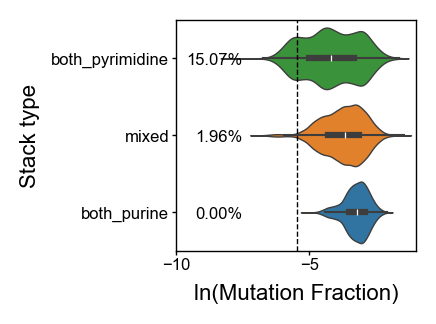

In [74]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
df_cc["stack_type"] = df_cc.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_cc,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
format_small_plot(ax)

## C in C-U sequence preferences


In [56]:
df_cu = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CU'").copy()
create_summary_table(df_cu, "p5_res")
create_summary_table(df_cu, "p3_res")
create_summary_table(df_cu, "stack_type")

Summary table for p5_res:
| p5_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| U        | 21.98%          |    4850 |
| C        | 18.99%          |    5871 |
| A        | 11.34%          |    5891 |
| G        | 2.49%           |    4024 |
Summary table for p3_res:
| p3_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| U        | 40.22%          |    6867 |
| A        | 3.34%           |    4104 |
| C        | 0.74%           |    5707 |
| G        | 0.20%           |    3958 |
Summary table for stack_type:
| stack_type      | % Under -5.45   |   Count |
|:----------------|:----------------|--------:|
| both_pyrimidine | 32.31%          |    6342 |
| mixed           | 8.36%           |   10611 |
| both_purine     | 0.35%           |    3683 |


/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


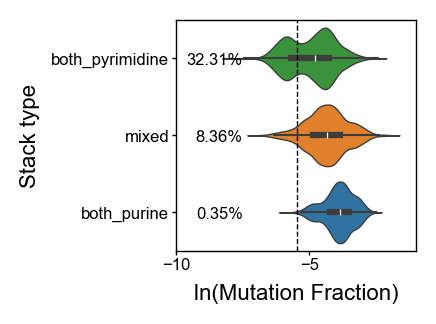

In [75]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_cu = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CU'").copy()
df_cu["stack_type"] = df_cu.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_cu,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
format_small_plot(ax)

In [57]:
create_summary_table(df_cu, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| UU        | 62.92%          |    1618 |
| CU        | 50.73%          |    1997 |
| AU        | 35.44%          |    1823 |
| CA        | 6.55%           |    1298 |
| GU        | 5.95%           |    1429 |
| UA        | 4.53%           |     905 |
| GC        | 0.90%           |    1218 |
| CC        | 0.83%           |    1330 |
| AC        | 0.74%           |    1762 |
| AA        | 0.60%           |    1170 |
| GA        | 0.55%           |     731 |
| UC        | 0.50%           |    1397 |
| CG        | 0.48%           |    1246 |
| AG        | 0.18%           |    1136 |
| GG        | 0.00%           |     646 |
| UG        | 0.00%           |     930 |


# Effects on 2x2 topology sequences preferences

This is the largest set of mutations isolating other effects

## A in A-A 2x2

In [60]:
df_aa = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA' and m_token == '2x2'"
).copy()
create_summary_table(df_aa, "p5_res")
create_summary_table(df_aa, "p3_res")
create_summary_table(df_aa, "stack_type")

Summary table for p5_res:
| p5_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| A        | 11.31%          |    7013 |
| U        | 7.01%           |    6294 |
| G        | 4.24%           |    5514 |
| C        | 3.88%           |    6343 |
Summary table for p3_res:
| p3_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| A        | 13.47%          |    7802 |
| U        | 5.31%           |    5513 |
| C        | 3.89%           |    6347 |
| G        | 2.24%           |    5502 |
Summary table for stack_type:
| stack_type      | % Under -5.45   |   Count |
|:----------------|:----------------|--------:|
| both_purine     | 8.97%           |    6610 |
| mixed           | 8.05%           |   12611 |
| both_pyrimidine | 1.78%           |    5943 |


In [61]:
create_summary_table(df_aa, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| AA        | 16.10%          |    2075 |
| UA        | 14.07%          |    1954 |
| AU        | 13.33%          |    1575 |
| GA        | 12.08%          |    1780 |
| AC        | 11.77%          |    1784 |
| CA        | 11.39%          |    1993 |
| UG        | 5.22%           |    1360 |
| UU        | 4.68%           |    1390 |
| AG        | 2.47%           |    1579 |
| UC        | 1.89%           |    1590 |
| GU        | 0.94%           |    1173 |
| CG        | 0.58%           |    1387 |
| CU        | 0.51%           |    1375 |
| GG        | 0.43%           |    1176 |
| CC        | 0.25%           |    1588 |
| GC        | 0.22%           |    1385 |


## A in A-C 2x2 

In [63]:
df_ac = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC' and m_token == '2x2'"
).copy()
create_summary_table(df_ac, "p5_res")
create_summary_table(df_ac, "p3_res")
create_summary_table(df_ac, "stack_type")

Summary table for p5_res:
| p5_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| U        | 4.64%           |    5067 |
| A        | 2.22%           |    4363 |
| G        | 2.03%           |    3490 |
| C        | 0.31%           |    3573 |
Summary table for p3_res:
| p3_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| U        | 6.72%           |    4585 |
| A        | 1.56%           |    2950 |
| C        | 0.87%           |    6872 |
| G        | 0.00%           |    2086 |
Summary table for stack_type:
| stack_type      | % Under -5.45   |   Count |
|:----------------|:----------------|--------:|
| both_pyrimidine | 3.47%           |    5967 |
| mixed           | 2.45%           |    8163 |
| both_purine     | 0.30%           |    2363 |


In [64]:
create_summary_table(df_ac, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| UU        | 11.09%          |    1389 |
| AU        | 6.72%           |    1191 |
| GU        | 6.36%           |    1022 |
| UA        | 3.84%           |     990 |
| UC        | 2.15%           |    2002 |
| CU        | 0.92%           |     983 |
| AA        | 0.91%           |     766 |
| AC        | 0.55%           |    1804 |
| GC        | 0.41%           |    1473 |
| CA        | 0.17%           |     594 |
| CC        | 0.06%           |    1593 |
| AG        | 0.00%           |     602 |
| GA        | 0.00%           |     600 |
| CG        | 0.00%           |     403 |
| GG        | 0.00%           |     395 |
| UG        | 0.00%           |     686 |


## A in A-G 2x2 

In [67]:
df_ag = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AG' and m_token == '2x2'"
).copy()
create_summary_table(df_ag, "p5_res")
create_summary_table(df_ag, "p3_res")
create_summary_table(df_ag, "stack_type")

Summary table for p5_res:
| p5_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| A        | 28.69%          |    3897 |
| C        | 23.26%          |    2846 |
| U        | 20.56%          |    3741 |
| G        | 13.62%          |    3459 |
Summary table for p3_res:
| p3_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| A        | 31.19%          |    5762 |
| C        | 22.46%          |    2907 |
| U        | 17.48%          |    3123 |
| G        | 1.12%           |    2151 |
Summary table for stack_type:
| stack_type      | % Under -5.45   |   Count |
|:----------------|:----------------|--------:|
| both_purine     | 24.10%          |    4170 |
| both_pyrimidine | 21.62%          |    2844 |
| mixed           | 20.20%          |    6929 |


In [66]:
create_summary_table(df_ag, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CA        | 39.63%          |    1181 |
| AA        | 36.07%          |    1666 |
| UC        | 32.78%          |     778 |
| AU        | 31.79%          |     972 |
| GA        | 28.17%          |    1349 |
| AC        | 27.26%          |     675 |
| CC        | 25.80%          |     690 |
| UA        | 22.22%          |    1566 |
| UU        | 20.93%          |     793 |
| GU        | 7.10%           |     775 |
| GC        | 4.71%           |     764 |
| AG        | 4.11%           |     584 |
| CU        | 2.74%           |     583 |
| CG        | 0.00%           |     392 |
| GG        | 0.00%           |     571 |
| UG        | 0.00%           |     604 |


## C in C-A 2x2 




In [68]:
df_ca = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA' and m_token == '2x2'"
).copy()
create_summary_table(df_ca, "p5_res")
create_summary_table(df_ca, "p3_res")
create_summary_table(df_ca, "stack_type")

Summary table for p5_res:
| p5_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| C        | 15.68%          |    4311 |
| A        | 0.66%           |    4555 |
| G        | 0.35%           |    2293 |
| U        | 0.19%           |    5334 |
Summary table for p3_res:
| p3_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| U        | 11.31%          |    3589 |
| A        | 3.20%           |    6840 |
| C        | 2.98%           |    3286 |
| G        | 0.04%           |    2778 |
Summary table for stack_type:
| stack_type      | % Under -5.45   |   Count |
|:----------------|:----------------|--------:|
| both_pyrimidine | 11.41%          |    4093 |
| mixed           | 3.07%           |    8334 |
| both_purine     | 0.02%           |    4066 |


In [69]:
create_summary_table(df_ca, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CU        | 38.82%          |     997 |
| CA        | 12.05%          |    1792 |
| CC        | 9.93%           |     725 |
| AC        | 2.42%           |     991 |
| GU        | 1.76%           |     398 |
| AU        | 0.60%           |     992 |
| UU        | 0.50%           |    1202 |
| UC        | 0.17%           |    1169 |
| CG        | 0.13%           |     797 |
| UA        | 0.10%           |    1975 |
| GA        | 0.08%           |    1297 |
| UG        | 0.00%           |     988 |
| GG        | 0.00%           |     197 |
| AA        | 0.00%           |    1776 |
| AG        | 0.00%           |     796 |
| GC        | 0.00%           |     401 |


## C in C-C 2x2 

In [70]:
df_cc = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC' and m_token == '2x2'"
).copy()
create_summary_table(df_cc, "p5_res")
create_summary_table(df_cc, "p3_res")
create_summary_table(df_cc, "stack_type")

Summary table for p5_res:
| p5_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| C        | 21.07%          |    2800 |
| A        | 0.91%           |    4062 |
| U        | 0.91%           |    4846 |
| G        | 0.18%           |    1666 |
Summary table for p3_res:
| p3_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| U        | 8.07%           |    3360 |
| C        | 6.73%           |    5972 |
| A        | 0.04%           |    2586 |
| G        | 0.00%           |    1456 |
Summary table for stack_type:
| stack_type      | % Under -5.45   |   Count |
|:----------------|:----------------|--------:|
| both_pyrimidine | 12.42%          |    5096 |
| mixed           | 0.60%           |    6786 |
| both_purine     | 0.00%           |    1492 |


In [71]:
create_summary_table(df_cc, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CC        | 30.88%          |    1143 |
| CU        | 30.27%          |     783 |
| UU        | 2.27%           |    1189 |
| AC        | 1.79%           |    1785 |
| UC        | 0.81%           |    1981 |
| AU        | 0.51%           |     987 |
| GU        | 0.50%           |     401 |
| UA        | 0.10%           |     993 |
| GC        | 0.09%           |    1063 |
| AA        | 0.00%           |     798 |
| GA        | 0.00%           |     202 |
| AG        | 0.00%           |     492 |
| CA        | 0.00%           |     593 |
| CG        | 0.00%           |     281 |
| UG        | 0.00%           |     683 |


## C in C-U 2x2 


In [72]:
df_cu = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CU' and m_token == '2x2'"
).copy()
create_summary_table(df_cu, "p5_res")
create_summary_table(df_cu, "p3_res")
create_summary_table(df_cu, "stack_type")

Summary table for p5_res:
| p5_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| U        | 22.40%          |    4692 |
| C        | 19.12%          |    5690 |
| A        | 12.71%          |    5242 |
| G        | 2.56%           |    3870 |
Summary table for p3_res:
| p3_res   | % Under -5.45   |   Count |
|:---------|:----------------|--------:|
| U        | 41.38%          |    6612 |
| A        | 3.30%           |    3974 |
| C        | 0.65%           |    5247 |
| G        | 0.08%           |    3661 |
Summary table for stack_type:
| stack_type      | % Under -5.45   |   Count |
|:----------------|:----------------|--------:|
| both_pyrimidine | 32.60%          |    6190 |
| mixed           | 8.85%           |    9861 |
| both_purine     | 0.38%           |    3443 |


In [73]:
create_summary_table(df_cu, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| UU        | 63.92%          |    1577 |
| CU        | 50.94%          |    1961 |
| AU        | 38.26%          |    1686 |
| CA        | 6.34%           |    1261 |
| GU        | 6.05%           |    1388 |
| UA        | 4.63%           |     864 |
| GC        | 0.93%           |    1182 |
| AC        | 0.85%           |    1413 |
| CC        | 0.62%           |    1293 |
| AA        | 0.61%           |    1149 |
| GA        | 0.57%           |     700 |
| UC        | 0.22%           |    1359 |
| AG        | 0.20%           |     994 |
| CG        | 0.09%           |    1175 |
| GG        | 0.00%           |     600 |
| UG        | 0.00%           |     892 |
